# Unzip files

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Sep 24 16:58:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ls /content

1.zip  sample_data


In [ ]:
!unzip /content/1.zip

Archive:  /content/1.zip
  inflating: Ubuntu-dialogue-corpus/dialogueText.csv  
  inflating: Ubuntu-dialogue-corpus/dialogueText_196.csv  
  inflating: Ubuntu-dialogue-corpus/dialogueText_301.csv  
  inflating: toc.csv                 


In [ ]:
cd /content/Ubuntu-dialogue-corpus

/content/Ubuntu-dialogue-corpus


# Import Libraries

In [ ]:
%pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 36.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.0 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.
numba 0.56.

In [ ]:
import random
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.manifold import TSNE
import pyLDAvis
#import pyLDAvis.sklearn
import os

In [ ]:
# Directory containing the CSV files
dir_name = '/content/Ubuntu-dialogue-corpus'
# Output CSV file
output_file = '/content/Ubuntu-dialogue-corpus/merged.csv'

# Initialize an empty list to store DataFrames
dfs = []

# Loop through all files in the directory
for item in os.listdir(dir_name):
    # Check if the item is a CSV file
    if item.endswith('.csv'):
        file_path = os.path.join(dir_name, item)
        # Read CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Append DataFrame to list
        dfs.append(df)

# Concatenate all DataFrames
merged_df = pd.concat(dfs, ignore_index=True)
# Write merged DataFrame to CSV
merged_df.to_csv(output_file, index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define the file path
file_path = '/content/Ubuntu-dialogue-corpus/merged.csv'

# Read the first few lines of the file to understand its structure and content
preview_data = pd.read_csv(file_path, nrows=5)
preview_data.head()

In [ ]:
# Determine the total number of rows in the file
total_rows = sum(1 for line in open(file_path)) - 1  # Subtract 1 to exclude the header row

total_rows

### Make data set smaler

In [ ]:
# Calculate the sample size based on 10-15% of the total rows
sample_size = int(total_rows * 0.10)

# Randomly select a subset of row indices for sampling
random.seed(42)  # For reproducibility
skip_rows = sorted(random.sample(range(1, total_rows + 1), total_rows - sample_size))  # Exclude the header row

# Read the sampled data
sampled_data = pd.read_csv(file_path, skiprows=skip_rows)

# Show the first few rows of the sampled data
sampled_data.head()
sampled_data.count()

In [ ]:
%pip install nltk

In [ ]:
# Import required libraries for text preprocessing
nltk.download('stopwords')

# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = ' '.join(stemmer.stem(word) for word in text.split() if word not in stop_words)  # Remove stopwords and stem
    return text
# Convert all entries in 'text' column to string
sampled_data['text'] = sampled_data['text'].astype(str)
# Apply preprocessing to the 'text' column
sampled_data['processed_text'] = sampled_data['text'].apply(preprocess_text)
# Show first few rows of the data after preprocessing
print(sampled_data[['text', 'processed_text']].head())

In [ ]:
sampled_data.to_csv('sampled_data_01.csv')

In [ ]:
sampled_data.count()

In [ ]:
# Check for GPU availability
#sampled_data = pd.read_csv('sampled_data.csv')
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TensorFlow")

def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)] = ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topic_dict

# First LDA model with initial parameters
vectorizer1 = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
X1 = vectorizer1.fit_transform(sampled_data['processed_text'])
lda_model1 = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model1.fit(X1)
feature_names1 = vectorizer1.get_feature_names_out()
topics1 = display_topics(lda_model1, feature_names1, 5)

# Plotting for the first LDA model
plt.figure(figsize=(15, 8))
plt.barh(range(len(topics1)), [5]*len(topics1), tick_label=list(topics1.keys()))
plt.xlabel('Topic Weight')
plt.title('Top 5 Words for Each Topic (Initial Dataset)')
plt.show()

# Second LDA model with reduced features
vectorizer2 = CountVectorizer(max_df=0.95, min_df=0.01, max_features=500)
X2 = vectorizer2.fit_transform(sampled_data['processed_text'])
lda_model2 = LatentDirichletAllocation(n_components=5, random_state=42, max_iter=10)
lda_model2.fit(X2)
feature_names2 = vectorizer2.get_feature_names_out()
topics2 = display_topics(lda_model2, feature_names2, 5)

# Plotting for the second LDA model
plt.figure(figsize=(15, 8))
plt.barh(range(len(topics2)), [5]*len(topics2), tick_label=list(topics2.keys()))
plt.xlabel('Topic Weight')
plt.title('Top 5 Words for Each Topic (Reduced Dataset)')
plt.show()

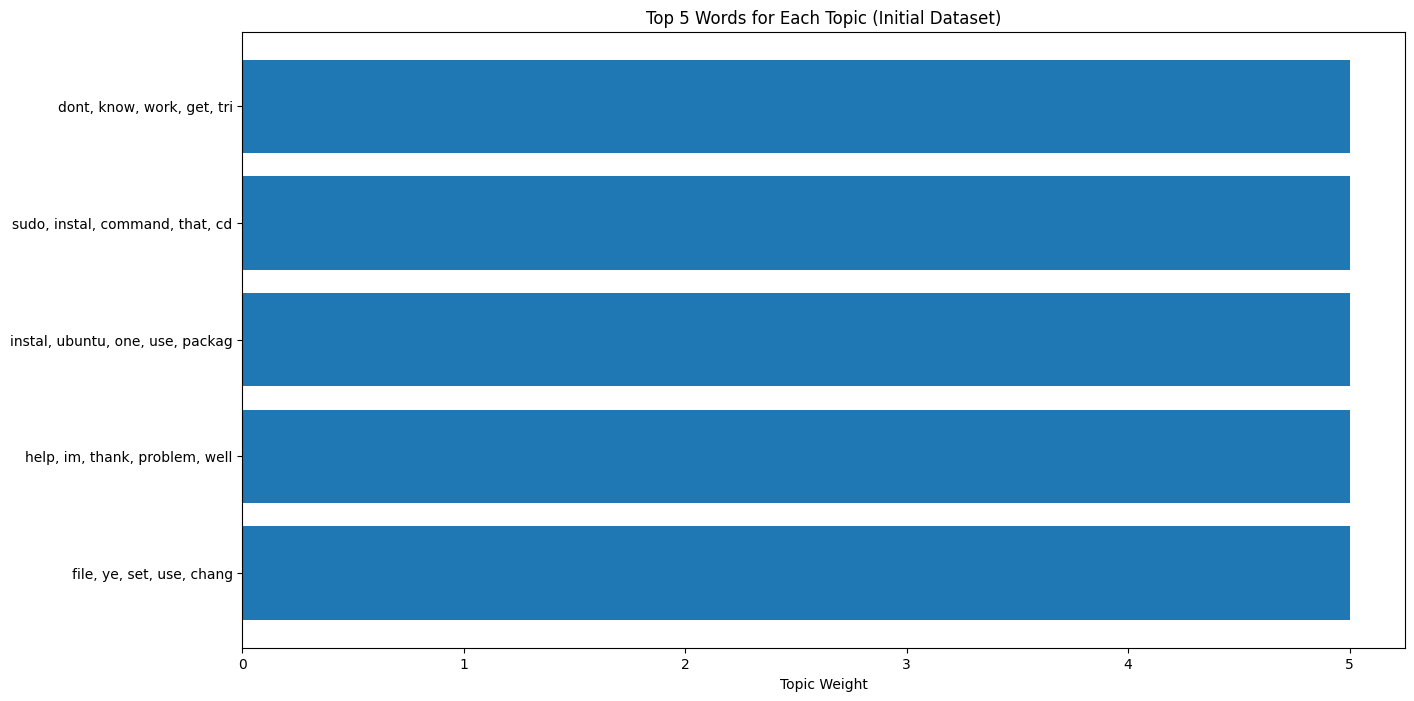

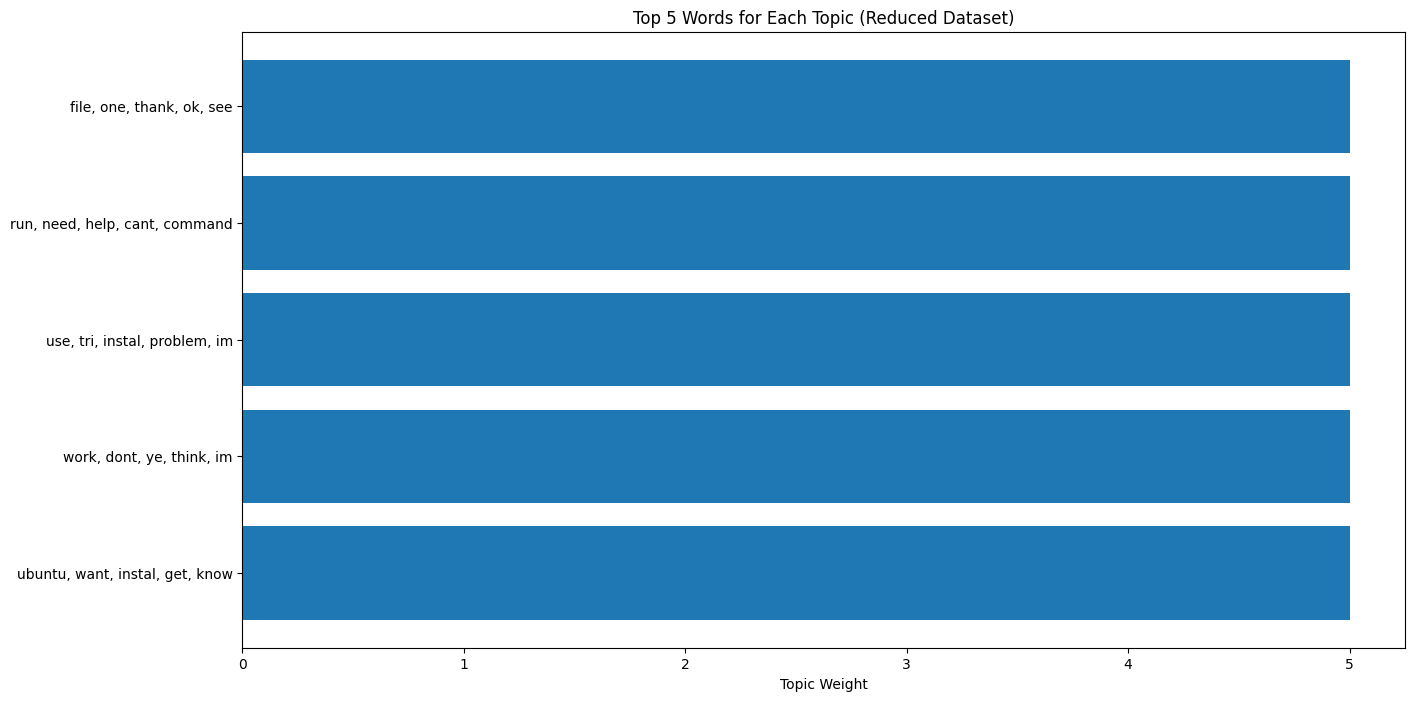

In [ ]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_words = ['{}'.format(feature_names[i]) for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict[", ".join(topic_words)] = topic_words
    return topic_dict
topics1 = display_topics(lda_model1, feature_names1, 5)
topics2 = display_topics(lda_model2, feature_names2, 5)

# Plotting for the first LDA model
plt.figure(figsize=(15, 8))
plt.barh(range(len(topics1)), [5]*len(topics1), tick_label=list(topics1.keys()))
plt.xlabel('Topic Weight')
plt.title('Top 5 Words for Each Topic (Initial Dataset)')
plt.show()

# Plotting for the second LDA model
plt.figure(figsize=(15, 8))
plt.barh(range(len(topics2)), [5]*len(topics2), tick_label=list(topics2.keys()))
plt.xlabel('Topic Weight')
plt.title('Top 5 Words for Each Topic (Reduced Dataset)')
plt.show()

Distribution of sentiment scores in the dialogues. Most dialogues have a neutral sentiment score close to zero. This is likely because the dialogues contain technical discussions where emotional words are less frequently used.

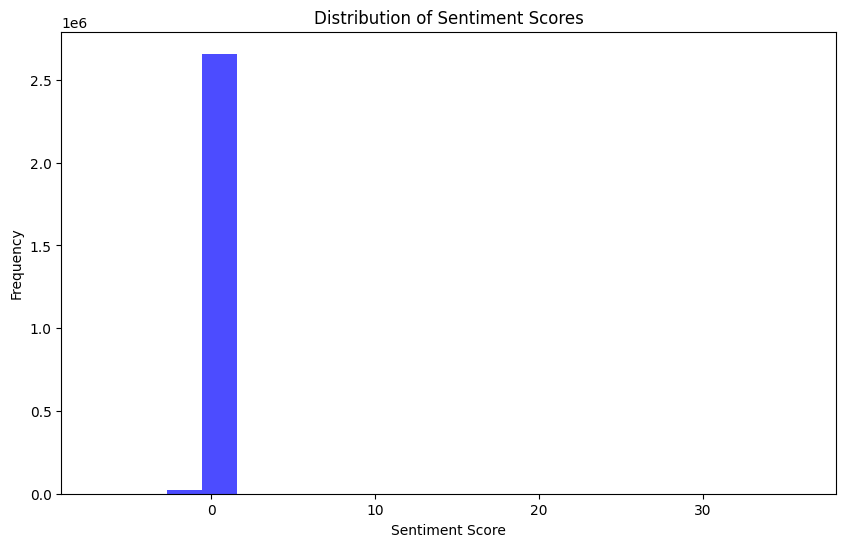

In [ ]:
# Define lists of positive and negative words (simplified for this example)
positive_words = ['good', 'great', 'excellent', 'positive', 'happy', 'success', 'love']
negative_words = ['bad', 'poor', 'negative', 'unhappy', 'fail', 'hate', 'sad']

# Function to calculate sentiment score
def calculate_sentiment(text):
    text_words = text.split()
    positive_count = sum(1 for word in text_words if word in positive_words)
    negative_count = sum(1 for word in text_words if word in negative_words)
    return positive_count - negative_count

# Apply the function to the 'processed_text' column
sampled_data['sentiment_score'] = sampled_data['processed_text'].apply(calculate_sentiment)

# Plotting the sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(sampled_data['sentiment_score'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()


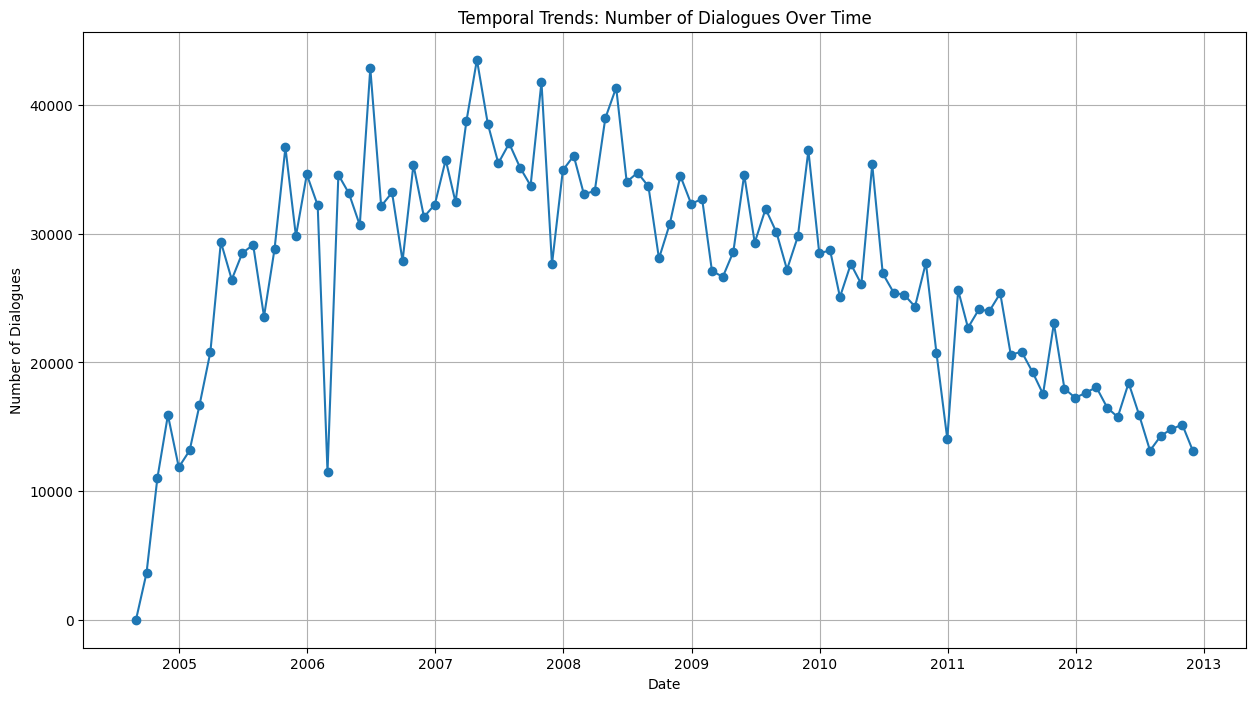

In [ ]:
# Convert the 'date' column to datetime format
sampled_data['date'] = pd.to_datetime(sampled_data['date'], errors='coerce')

# Drop rows where 'date' could not be converted to datetime
sampled_data.dropna(subset=['date'], inplace=True)

# Resample the data by month and count the number of dialogues
time_series_data = sampled_data.resample('M', on='date').size()

# Plotting the temporal trends
plt.figure(figsize=(15, 8))
plt.plot(time_series_data.index, time_series_data.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Dialogues')
plt.title('Temporal Trends: Number of Dialogues Over Time')
plt.grid(True)
plt.show()

### Word Clouds for Each Topic

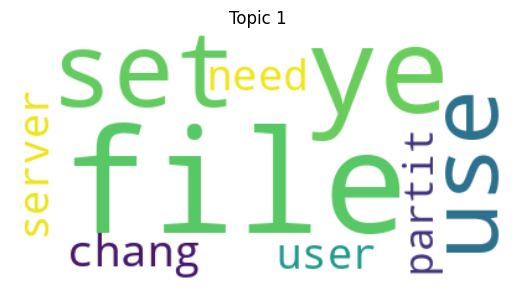

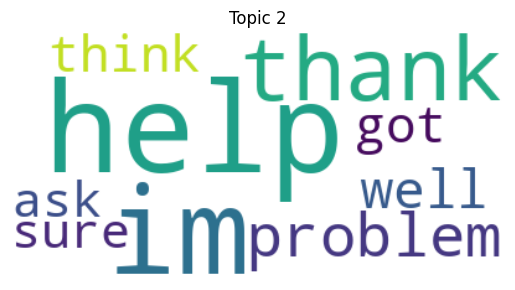

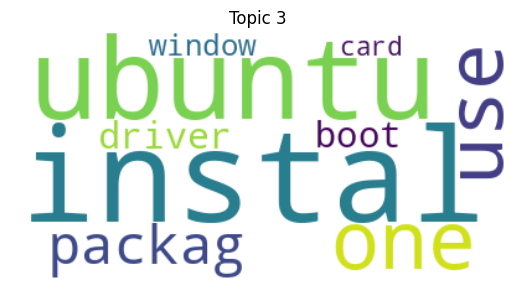

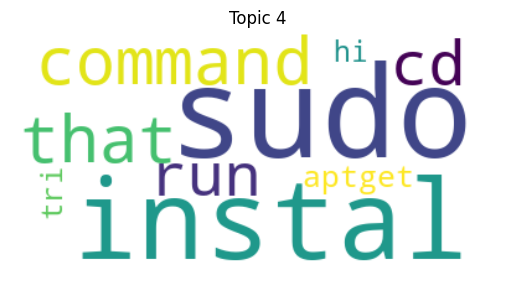

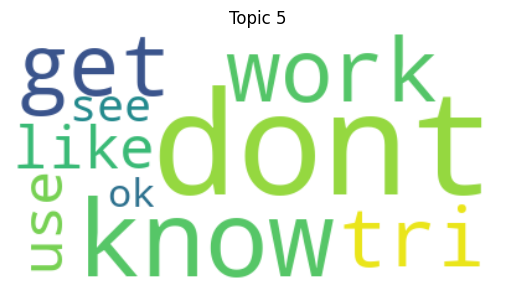

In [ ]:
for idx, topic in enumerate(lda_model1.components_):
    wordcloud = WordCloud(background_color='white').generate_from_frequencies({feature_names1[i]: topic[i] for i in topic.argsort()[:-10:-1]})
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {idx + 1}')
    plt.show()

### Heatmap of Topic-Word Distributions

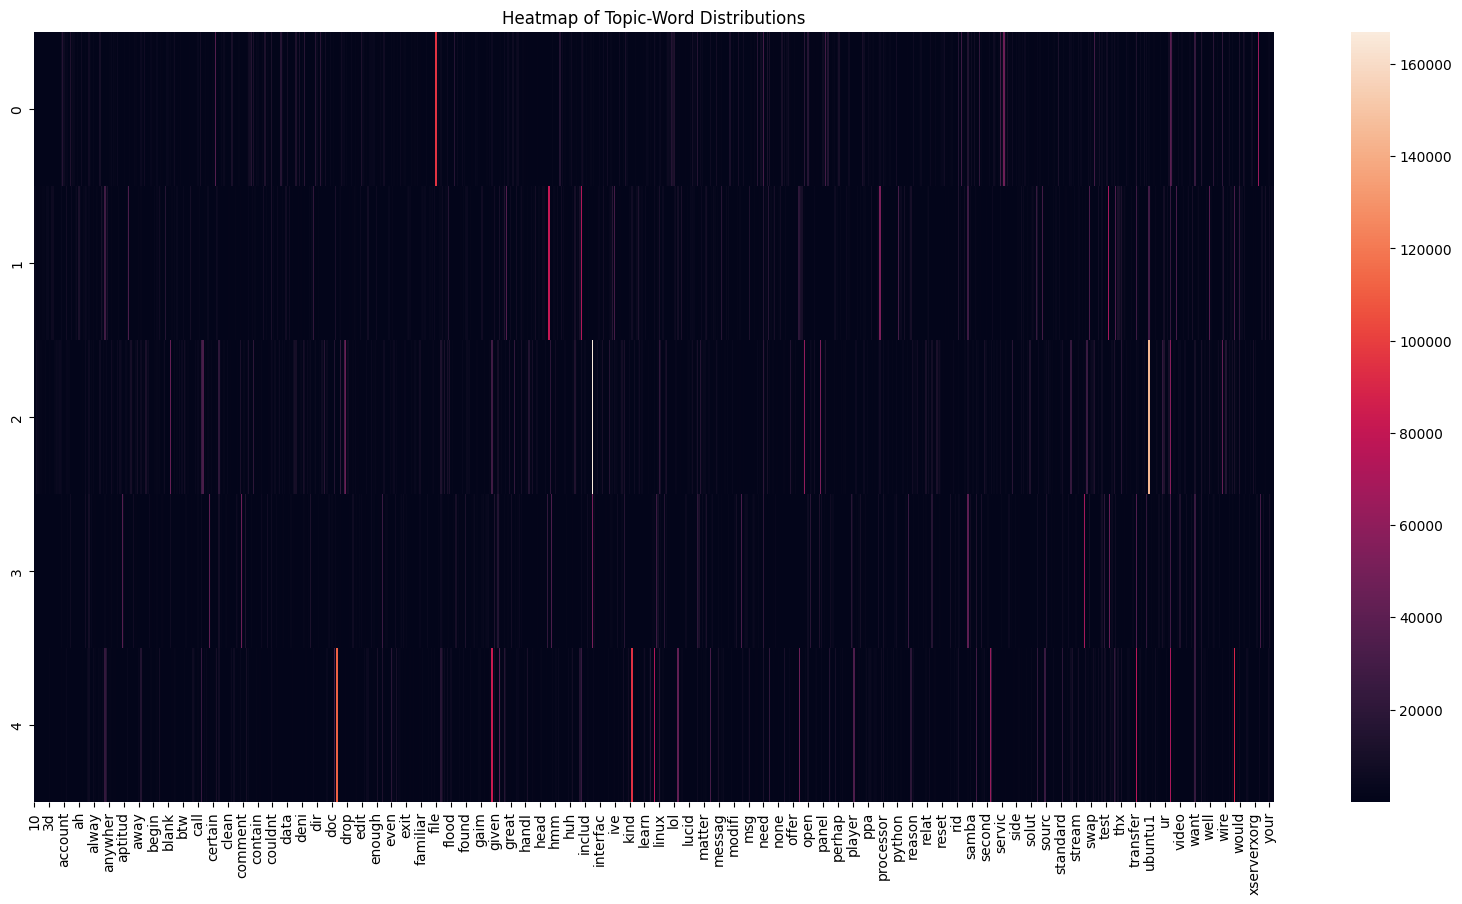

In [ ]:
topic_word_distributions = pd.DataFrame(lda_model1.components_, columns=feature_names1)
plt.figure(figsize=(20, 10))
sns.heatmap(topic_word_distributions)
plt.title('Heatmap of Topic-Word Distributions')
plt.show()

In [ ]:
# Check for GPU availability
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TensorFlow")
doc_topic_distr = lda_model1.transform(X1)
tsne_model = TSNE(n_components=2, verbose=1, random_state=42)
tsne_lda = tsne_model.fit_transform(doc_topic_distr)
plt.scatter(tsne_lda[:, 0], tsne_lda[:, 1], c=[item.argmax() for item in doc_topic_distr])
plt.title('t-SNE plot of Document-Topic Distributions')
plt.show()

Default GPU Device: /device:GPU:0


NameError: ignored

t-Distributed Stochastic Neighbor Embedding can be used to reduce the dimensionality of the document-topic matrix and visualize it in a 2D space

In [ ]:
# Check for GPU availability
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TensorFlow")
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model1, X1, vectorizer1, mds='tsne')
panel